
# Image Restoration via Total Variation Regularization

This notebook implements a simple **image denoising** pipeline using
(smoothed) **total variation (TV) regularization** and gradient descent.

We:

1. Construct a synthetic $64 \times 64$ grayscale image of the letter **"U"**.
2. Add Gaussian noise with different standard deviations.
3. Perform TV-regularized gradient descent to denoise the image.
4. Visualize the results in a multi-panel figure and save it to disk so it can be included in LaTeX.

Compared to the earlier version, we:

- Use more conservative step sizes to avoid instability for large $\lambda$.
- Choose $\lambda$ values that give a smoother, cleaner progression.
- Include the **clean reference image** in the multi-panel figure.
- Make the **row/column labeling** more explicit (top row: noise level, left column: $\lambda$).


In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt

# Make sure figures directory exists
os.makedirs("figs", exist_ok=True)

rng = np.random.default_rng(12345)


## 1. Construct a synthetic $64 \times 64$ image of the letter `U`

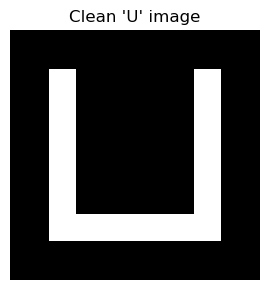

In [2]:

def make_U_image(size: int = 64, thickness: int = 8) -> np.ndarray:
    """Create a simple block-letter 'U' on a dark background.

    Parameters
    ----------
    size : int
        Image size (size x size).
    thickness : int
        Stroke thickness of the letter.

    Returns
    -------
    img : np.ndarray
        Float32 image with values in [0, 1].
    """
    img = np.zeros((size, size), dtype=np.float32)

    # Vertical bars of the "U"
    margin = size // 6
    left_col = margin
    right_col = size - margin - 1

    img[margin : size - margin, left_col : left_col + thickness] = 1.0
    img[margin : size - margin, right_col - thickness + 1 : right_col + 1] = 1.0

    # Bottom bar of the "U"
    bottom_row = size - margin - 1
    img[bottom_row - thickness + 1 : bottom_row + 1, left_col : right_col + 1] = 1.0

    return img


base_img = make_U_image(size=64, thickness=7)

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(base_img, cmap="gray", vmin=0.0, vmax=1.0)
ax.set_title("Clean 'U' image")
ax.axis("off")
plt.tight_layout()
plt.show()


## 2. Add Gaussian noise and define TV-regularized energy and its gradient

In [3]:

def add_gaussian_noise(image: np.ndarray, sigma: float) -> np.ndarray:
    """Add i.i.d. Gaussian noise with standard deviation `sigma` in [0,1] scale.

    Image values are clipped back to [0, 1].
    """
    noisy = image + rng.normal(loc=0.0, scale=sigma, size=image.shape)
    return np.clip(noisy, 0.0, 1.0)


def tv_energy(u: np.ndarray, w: np.ndarray, lam: float, eps: float = 1e-3) -> float:
    """Smoothed isotropic total variation energy:

        E(u) = 0.5 * ||u - w||^2 + lam * sum sqrt(eps^2 + |∇u|^2).

    Here ∇u is approximated with forward finite differences.
    """
    diff = u - w
    data_term = 0.5 * np.sum(diff**2)

    # Forward differences (Neumann-like boundary: last row/col gradient = 0)
    dx = np.zeros_like(u)
    dy = np.zeros_like(u)
    dx[:, :-1] = u[:, 1:] - u[:, :-1]
    dy[:-1, :] = u[1:, :] - u[:-1, :]

    grad_sq = dx**2 + dy**2
    tv_term = lam * np.sum(np.sqrt(eps * eps + grad_sq))
    return float(data_term + tv_term)


def tv_grad(u: np.ndarray, w: np.ndarray, lam: float, eps: float = 1e-3) -> np.ndarray:
    """Gradient of smoothed isotropic TV energy with respect to u.

    Uses divergence of normalized gradient:
        ∂E/∂u = (u - w) - lam * div( ∇u / sqrt(eps^2 + |∇u|^2) ).

    Implemented with finite differences and zero-flux (Neumann) boundary conditions.
    """
    # Data term
    grad = u - w

    # Forward differences
    dx = np.zeros_like(u)
    dy = np.zeros_like(u)
    dx[:, :-1] = u[:, 1:] - u[:, :-1]
    dy[:-1, :] = u[1:, :] - u[:-1, :]

    # Normalized gradients
    denom = np.sqrt(eps * eps + dx * dx + dy * dy)
    gx = dx / denom
    gy = dy / denom

    # Divergence of g = (gx, gy)
    div = np.zeros_like(u)

    # x-direction divergence
    div[:, :-1] += gx[:, :-1]
    div[:, 1:] -= gx[:, :-1]

    # y-direction divergence
    div[:-1, :] += gy[:-1, :]
    div[1:, :] -= gy[:-1, :]

    grad -= lam * div
    return grad


def tv_denoise(
    w: np.ndarray,
    lam: float,
    n_iters: int = 250,
    base_step: float = 0.08,
    eps: float = 1e-3,
    verbose: bool = False,
) -> np.ndarray:
    """Perform gradient descent on TV-regularized energy starting from w.

    We scale the step size mildly with λ to avoid instability:

        step_eff = base_step / (1.0 + 4.0 * lam)

    Parameters
    ----------
    w : np.ndarray
        Noisy image.
    lam : float
        TV regularization strength.
    n_iters : int
        Number of gradient descent iterations.
    base_step : float
        Base step size (tuned for λ≈1).
    eps : float
        Smoothing parameter in TV.
    verbose : bool
        If True, print energy every 50 iterations.
    """
    u = w.copy().astype(np.float32)

    # Simple λ-dependent step-size heuristic
    step = base_step / (1.0 + 4.0 * lam)

    for k in range(n_iters):
        g = tv_grad(u, w, lam=lam, eps=eps)
        u -= step * g
        u = np.clip(u, 0.0, 1.0)
        if verbose and (k % 50 == 0 or k == n_iters - 1):
            E = tv_energy(u, w, lam=lam, eps=eps)
            print(f"Iter {k:4d}: E = {E:.4f}")
    return u


## 3. Multi-panel experiment: noise levels vs. regularization strengths

Saved figure to: figs/image_restoration_tv_grid.png


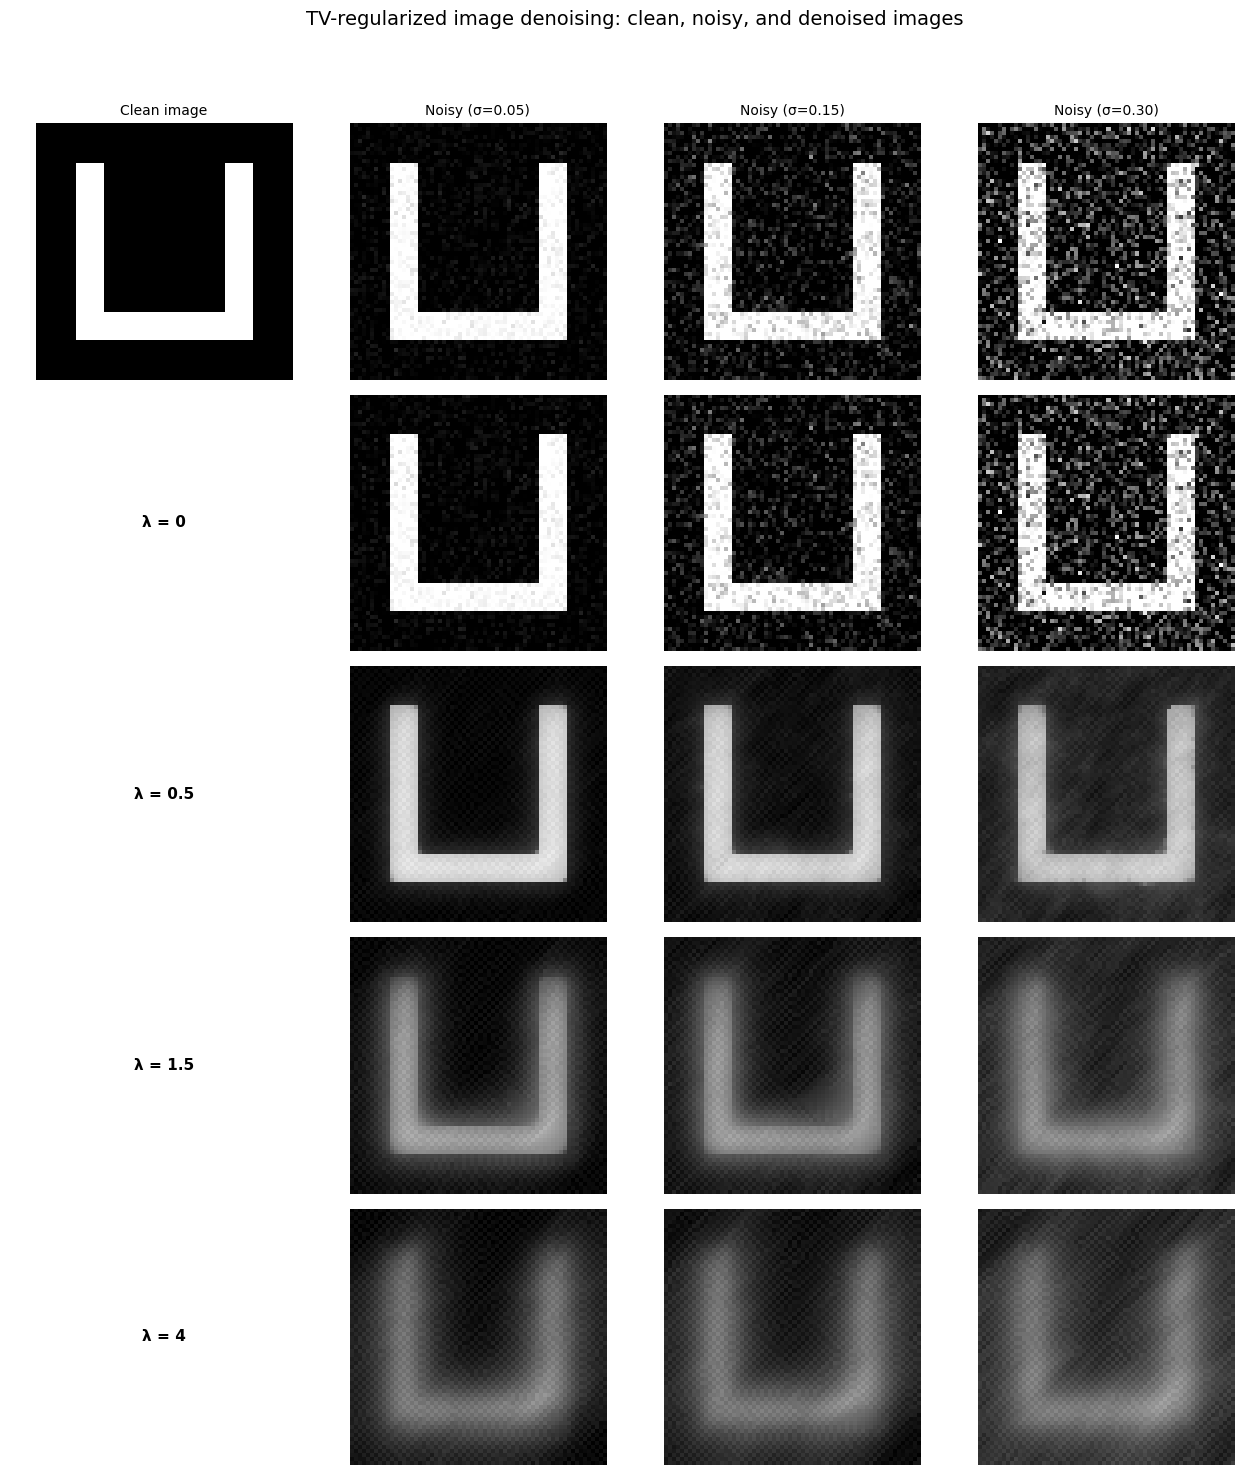

In [4]:

# Noise levels (standard deviations in [0,1] scale)
noise_sigmas = [0.05, 0.15, 0.30]   # low, medium, high noise

# TV regularization strengths
lambdas = [0.0, 0.5, 1.5, 4.0]      # no TV, weak, medium, strong

# Build figure with:
#   - first row: clean + noisy images for each sigma
#   - each subsequent row: one λ, columns = denoised images for each sigma
# leftmost column (row>0) is used as a λ-label panel.

n_rows = 1 + len(lambdas)
n_cols = 1 + len(noise_sigmas)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.2 * n_cols, 3.0 * n_rows))

# --- Top row: clean + noisy images ---
ax_clean = axes[0, 0]
ax_clean.imshow(base_img, cmap="gray", vmin=0.0, vmax=1.0)
ax_clean.set_title("Clean image", fontsize=10)
ax_clean.axis("off")

noisy_images = []
for j, sigma in enumerate(noise_sigmas):
    noisy = add_gaussian_noise(base_img, sigma)
    noisy_images.append(noisy)
    ax = axes[0, j + 1]
    ax.imshow(noisy, cmap="gray", vmin=0.0, vmax=1.0)
    ax.set_title(f"Noisy (σ={sigma:.2f})", fontsize=10)
    ax.axis("off")

# --- Denoised rows for each lambda ---
for i, lam in enumerate(lambdas):
    row = i + 1

    # Use left cell as a λ-label panel only
    ax_label = axes[row, 0]
    ax_label.axis("off")
    ax_label.text(
        0.5,
        0.5,
        f"λ = {lam:g}",
        ha="center",
        va="center",
        fontsize=11,
        fontweight="bold",
        transform=ax_label.transAxes,
    )

    for j, sigma in enumerate(noise_sigmas):
        noisy = noisy_images[j]
        if lam == 0.0:
            denoised = noisy
        else:
            denoised = tv_denoise(
                noisy,
                lam=lam,
                n_iters=250,
                base_step=0.08,
                eps=1e-3,
                verbose=False,
            )
        ax = axes[row, j + 1]
        ax.imshow(denoised, cmap="gray", vmin=0.0, vmax=1.0)
        ax.axis("off")

fig.suptitle(
    "TV-regularized image denoising: clean, noisy, and denoised images",

    fontsize=14,
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
out_path = os.path.join("figs", "image_restoration_tv_grid.png")
fig.savefig(out_path, dpi=200)
print(f"Saved figure to: {out_path}")
plt.show()


## 4. Optional: visualize energy decay for one $(\sigma, \lambda)$ pair

Saved energy figure to: figs/image_restoration_tv_energy.png


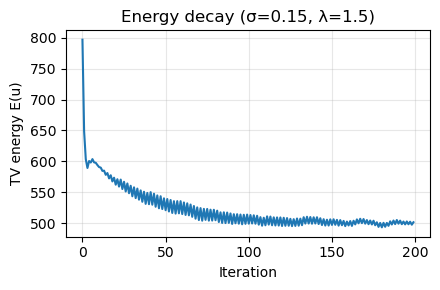

In [5]:

sigma_demo = 0.15
lam_demo = 1.5
noisy_demo = add_gaussian_noise(base_img, sigma_demo)

n_iters_demo = 200
base_step_demo = 0.08
step_demo = base_step_demo / (1.0 + 4.0 * lam_demo)

u = noisy_demo.copy().astype(np.float32)
energies = []

for k in range(n_iters_demo):
    g = tv_grad(u, noisy_demo, lam=lam_demo, eps=1e-3)
    u -= step_demo * g
    u = np.clip(u, 0.0, 1.0)
    E = tv_energy(u, noisy_demo, lam=lam_demo, eps=1e-3)
    energies.append(E)

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.plot(np.arange(n_iters_demo), energies, linewidth=1.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("TV energy E(u)")
ax.set_title(f"Energy decay (σ={sigma_demo}, λ={lam_demo})")
ax.grid(alpha=0.3)

energy_path = os.path.join("figs", "image_restoration_tv_energy.png")
fig.tight_layout()
fig.savefig(energy_path, dpi=200)
print(f"Saved energy figure to: {energy_path}")
plt.show()
